In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929 

In [66]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path

import random

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.7.1
torchvision version: 0.22.1


In [ ]:
from utils import data_setup, engine
from utils.helper_functions import download_data, plot_loss_curves

In [6]:
# device agnostic
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

1. Data preparation

In [12]:
# get data
image_path=Path("data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir=image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [15]:
# create datasets and turn into dataloader
# first create a transforms

IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
]
)
manual_transforms


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
BATCH_SIZE = 32 # Friends don't let friends use mini-batches larger than 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [34]:
# just check a single image to check -- always
# get a batch of images first
image_batch, label_batch=next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]
image.shape, label

/Users/mikeqin/code/ml-training/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(0))

2. Data understanding and verification

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

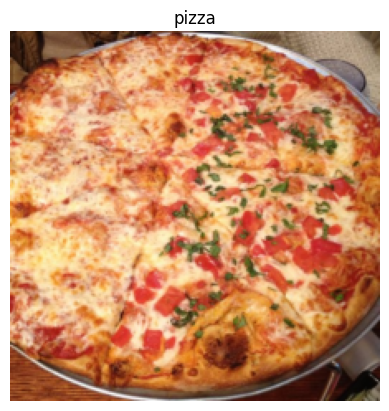

In [40]:
# plot it
# matplotlib like to have the color channel last so we have to permute the image
plt.imshow(image.permute(1,2,0)) # (color_channels, h, w)->(h, w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



Create image patches and turn them into patch embeddings

In [42]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [43]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


In [50]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


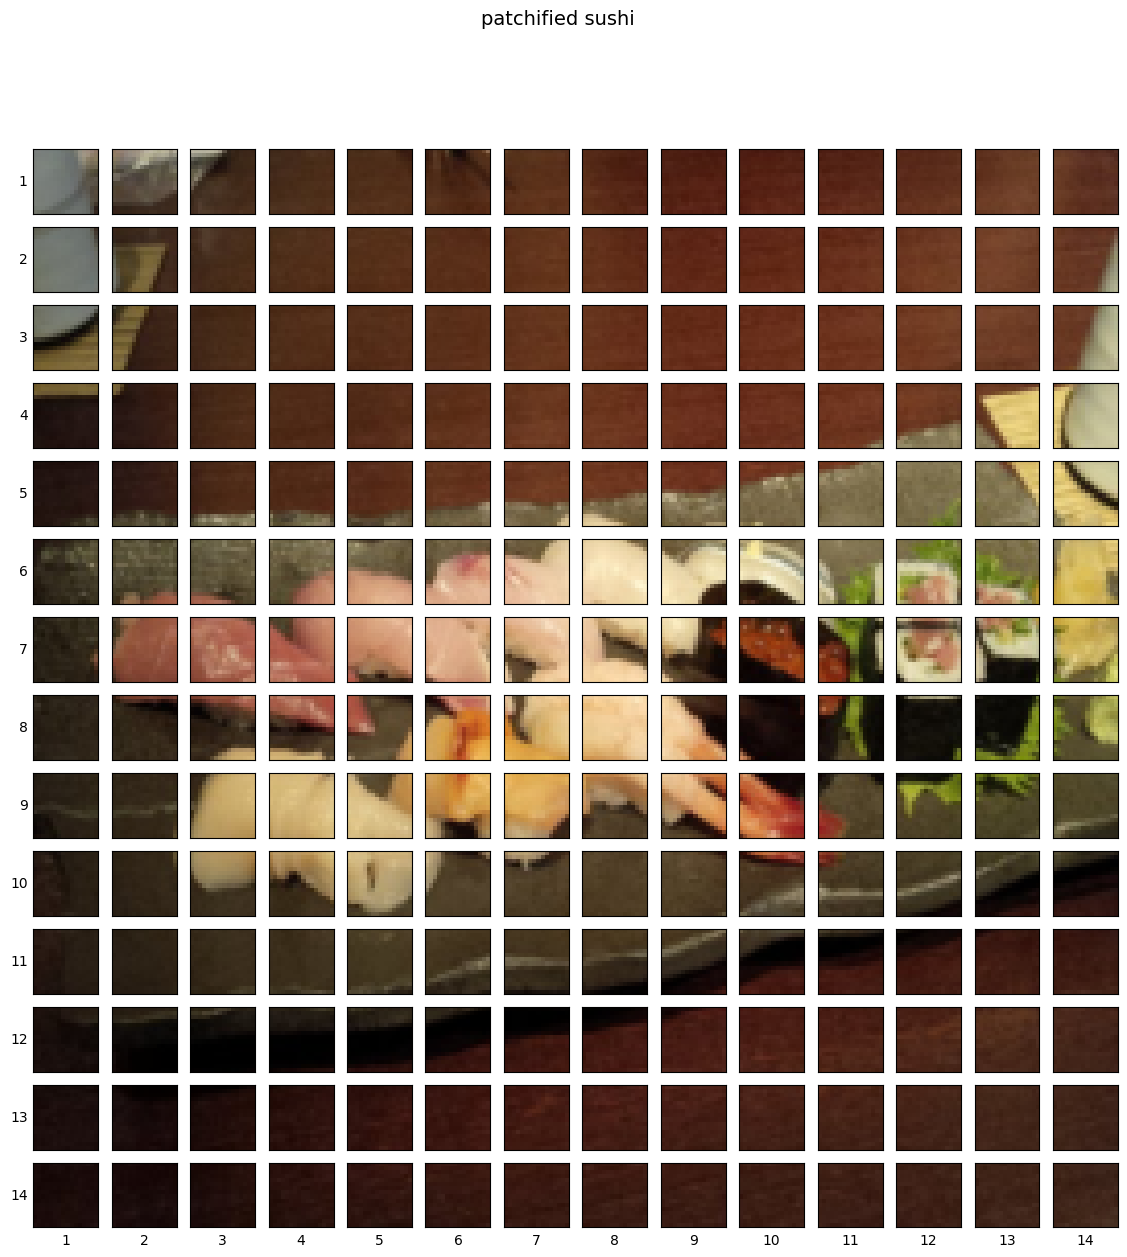

In [53]:
# Setup code to plot whole image as patches
img_size = 224
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"patchified {class_names[label]}", fontsize=14)
plt.show()

In [ ]:
# take a long time to create these patches. Conv2d is a good replacement

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1 for ViT-Base, that is, 3*16*16=768
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

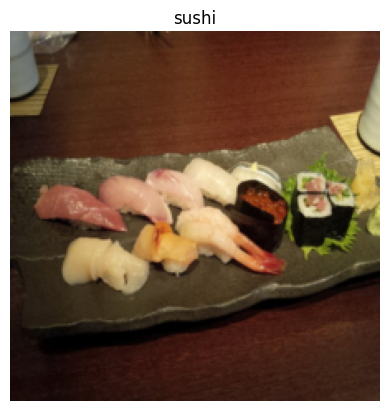

In [47]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [55]:
#pass the image through the converlutional layer
# learnable...
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape, image_out_of_conv.requires_grad

(torch.Size([1, 768, 14, 14]), True)

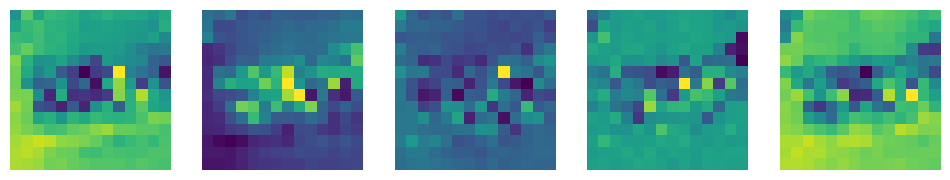

In [ ]:
# plot random convolutional feature maps (embeddings)
random_indexs = random.sample(range(0, 768), k =5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :]
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[]) #set_xticks([])
    ax[i].set(yticklabels=[])
    ax[i].axis(False)

In [69]:
#  the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension
#  we wanted to flat the dimentions of 14 and 14
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
image_of_conv_flattend = flatten_layer(image_out_of_conv)
image_of_conv_flattend.shape

torch.Size([1, 768, 196])

want: (batch_size, num_of_patches, embedding_dim)

In [71]:
image_of_conv_flattend_permuted = image_of_conv_flattend.permute(0,2,1)
image_of_conv_flattend_permuted.shape


torch.Size([1, 196, 768])

In [72]:
# visualize the single flattened feature map
single_flattened_feature_map = image_of_conv_flattend_permuted[:,:,0]
single_flattened_feature_map


tensor([[ 0.0137,  0.0518,  0.0609,  0.0489,  0.0565,  0.0513,  0.0656,  0.0655,
          0.0520,  0.0692,  0.0674,  0.0662,  0.0643,  0.0556, -0.0078,  0.0520,
          0.0426,  0.0678,  0.0602,  0.0600,  0.0696,  0.0667,  0.0710,  0.0656,
          0.0654,  0.0543,  0.0702, -0.0197,  0.0113,  0.1627,  0.0558,  0.0576,
          0.0551,  0.0662,  0.0783,  0.0684,  0.0770,  0.0663,  0.0693,  0.0722,
          0.0534,  0.0045,  0.0807,  0.0155,  0.0593,  0.0578,  0.0507,  0.0683,
          0.0767,  0.0744,  0.0636,  0.0821,  0.0478,  0.0747, -0.0949, -0.1147,
          0.0194,  0.0386,  0.0660,  0.0677,  0.0820,  0.0521,  0.0693,  0.1291,
          0.0334,  0.0526,  0.0105,  0.0188,  0.0002,  0.1677,  0.0205,  0.0369,
          0.0378, -0.0293,  0.0571,  0.0757,  0.0101, -0.0724,  0.0343, -0.1888,
          0.0732, -0.0400,  0.0201,  0.0851,  0.0189,  0.0533, -0.0061,  0.1237,
          0.0182,  0.0071, -0.0581,  0.1381, -0.0395, -0.0110,  0.0857,  0.0389,
         -0.0603,  0.1429,  

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

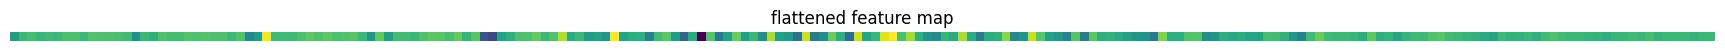

In [73]:
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title("flattened feature map")
plt.axis(False)

3. Enough experiment and verifications. Create embeddings

In [ ]:
# create patch embedding

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3,
                 embedding_dimention: int=768, # from table 1 for ViT-Base
                 patch_size:int=16):
        super().__init__()
        # self.patcher = nn.Conv2d(in_channels=in_channels,
        #               out_channels=embedding_dimention,
        #               kernel_size=patch_size,
        #               stride=patch_size,
        #               padding=0)
        # self.flatten = nn.Flatten(start_dim=2,
        #                           end_dim=3)
        
        # a sequence
        self.patch_and_flatten = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=embedding_dimention,
                      kernel_size=patch_size,
                      stride=patch_size,
                      padding=0),
            nn.Flatten(start_dim=2,
                      end_dim=3)
        )


    def forward(self, x):
        # check the image resolution is compatible 
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"image size {image_resolution} must be divisible by patch_size {patch_size}"

        #patched = self.patcher(x)
        #flattened = self.flatten(patched)
        flattened = self.patch_and_flatten(x)

        return flattened.permute(0,2,1)


In [88]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

print(f"image size: {image.unsqueeze(0).shape}")
patchify = PatchEmbedding()
patch_embedded_image=patchify(image.unsqueeze(0)) # add an extra batch dimension

patch_embedded_image.shape

image size: torch.Size([1, 3, 224, 224])


torch.Size([1, 196, 768])

In [ ]:
# adding class token embedding

In [89]:
# add position embedding